In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

from sklearn.ensemble import IsolationForest

# Load dataset

In [2]:
from sklearn.datasets import load_wine

wine = load_wine(return_X_y=False)
X = pd.DataFrame(wine.data, columns=wine.feature_names)
X.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



# Train a ML model

In [3]:
model = IsolationForest(behaviour="new", contamination="auto")
model.fit(X)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

# Define the game

In [4]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)

## Reward function

def fc(z):
    if model.decision_function(z.reshape(1,-1)) < 0:
        return 1
    else:
        return 0

In [5]:
fc = lambda x: model.decision_function(x.reshape(1,-1))[0]

### Pick an anomaly $x$

In [6]:
idx_anomaly = np.argwhere(model.predict(X) == -1).flatten()
idx_x = np.random.choice(idx_anomaly, size=1)[0]
x = X.iloc[idx_x,:]
x_score = fc(x.values)
print(x)
print()
print("Prediction for x: {0:.2f}".format(x_score))

alcohol                          11.56
malic_acid                        2.05
ash                               3.23
alcalinity_of_ash                28.50
magnesium                       119.00
total_phenols                     3.18
flavanoids                        5.08
nonflavanoid_phenols              0.47
proanthocyanins                   1.87
color_intensity                   6.00
hue                               0.93
od280/od315_of_diluted_wines      3.69
proline                         465.00
Name: 121, dtype: float64

Prediction for x: -0.09


### Single reference in normal class

In [7]:
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_r = np.random.choice(idx_normal, size=1)[0]
reference = X.iloc[idx_r,:]
ref_score = fc(reference.values)
print(reference)
print()
print("Prediction for this reference: {0:.2f}".format(ref_score))

alcohol                          12.04
malic_acid                        4.30
ash                               2.38
alcalinity_of_ash                22.00
magnesium                        80.00
total_phenols                     2.10
flavanoids                        1.75
nonflavanoid_phenols              0.42
proanthocyanins                   1.35
color_intensity                   2.60
hue                               0.79
od280/od315_of_diluted_wines      2.57
proline                         580.00
Name: 129, dtype: float64

Prediction for this reference: 0.07


#### Approximation methods

##### Monte Carlo 

In [8]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=100)
mc_shap

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


alcohol                        -0.008410
malic_acid                      0.019158
ash                            -0.025611
alcalinity_of_ash              -0.032242
magnesium                      -0.003448
total_phenols                  -0.010401
flavanoids                     -0.055103
nonflavanoid_phenols           -0.007507
proanthocyanins                -0.004406
color_intensity                -0.017223
hue                             0.001877
od280/od315_of_diluted_wines   -0.014679
proline                        -0.003303
dtype: float64

##### SGD

In [9]:
sgd_est = SGDshapley(d, C=1)
sgd_shap = sgd_est.sgd(x=x, fc=fc, ref=reference, n_iter=50, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 50/50 [00:01<00:00, 29.39it/s]


alcohol                         0.006377
malic_acid                      0.017274
ash                            -0.023484
alcalinity_of_ash              -0.027326
magnesium                      -0.007194
total_phenols                  -0.010928
flavanoids                     -0.027949
nonflavanoid_phenols           -0.018500
proanthocyanins                -0.011831
color_intensity                -0.021497
hue                            -0.013359
od280/od315_of_diluted_wines   -0.016948
proline                        -0.005933
dtype: float64

#### Plot 

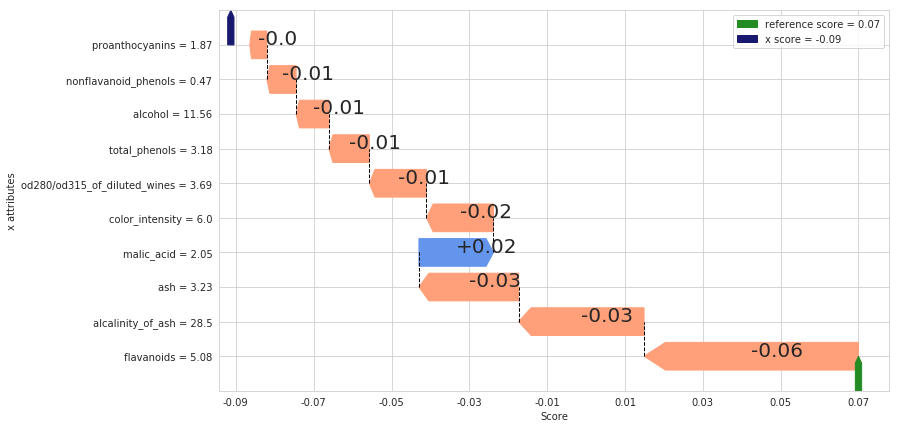

In [10]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=mc_shap, n_attributes=10)

### Several references 

In [11]:
n_ref = 10
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_ref = np.random.choice(idx_normal, size=n_ref, replace=False).flatten()
references = X.iloc[idx_ref,:]
references.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
35,13.48,1.81,2.41,20.5,100.0,2.70,2.98,0.26,1.86,5.10,1.04,3.47,920.0
47,13.90,1.68,2.12,16.0,101.0,3.10,3.39,0.21,2.14,6.10,0.91,3.33,985.0
79,12.70,3.87,2.40,23.0,101.0,2.83,2.55,0.43,1.95,2.57,1.19,3.13,463.0
99,12.29,3.17,2.21,18.0,88.0,2.85,2.99,0.45,2.81,2.30,1.42,2.83,406.0
166,13.45,3.70,2.60,23.0,111.0,1.70,0.92,0.43,1.46,10.68,0.85,1.56,695.0


#### Approximation methods

##### Monte Carlo 

In [12]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=100)
mc_shaps

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


alcohol                        -0.013380
malic_acid                      0.007298
ash                            -0.025069
alcalinity_of_ash              -0.031299
magnesium                      -0.011428
total_phenols                  -0.003057
flavanoids                     -0.053119
nonflavanoid_phenols           -0.007471
proanthocyanins                 0.004872
color_intensity                 0.000062
hue                             0.005376
od280/od315_of_diluted_wines   -0.004854
proline                        -0.004741
dtype: float64

#### Plots

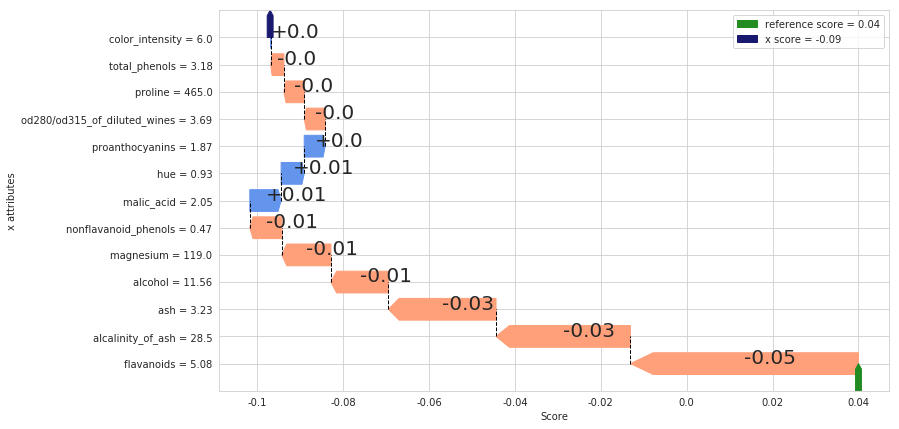

In [16]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps, n_attributes=15)